In [2]:
%load_ext autoreload
%autoreload 2

import os
import pandas as pd
import qgrid
import gensim
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
import nltk
os.chdir(os.getcwd() + '/..')
from data_io import *
from speech import *
import time

/Users/pmatias/Library/Python/3.8/lib/python/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


Loading w2v window=5 dimension=100...done
Loading w2v window=5 dimension=150...done
Loading w2v window=5 dimension=200...done
Loading w2v window=10 dimension=100...done
Loading w2v window=10 dimension=150...done
Loading w2v window=10 dimension=200...done
Loading w2v window=15 dimension=100...done
Loading w2v window=15 dimension=150...done
Loading w2v window=15 dimension=200...done
Loading w2v window=20 dimension=100...done
Loading w2v window=20 dimension=150...done
Loading w2v window=20 dimension=200...done


In [3]:
# Read data.
labeled = load_data()
unlabeled = load_unlabeled_data()
all_data = labeled.data + unlabeled.data

-- train data
4370
-- dev data
414
Reading unlabeled data


In [ ]:
# Get features
count_vect = CountVectorizer()
trainX = count_vect.fit_transform(labeled.data)
df = pd.DataFrame(trainX.todense(), columns=count_vect.get_feature_names())

# Add labels
df['y'] = labeled.labels

In [32]:
# Is democrat
is_dem = pd.DataFrame([
    ('OBAMA_PRIMARY2008', 1),
    ('PAUL_PRIMARY2012', 0),
    ('MCCAIN_PRIMARY2008', 0),
    ('CLINTON_PRIMARY2008', 1),
    ('ROMNEY_PRIMARY2008', 0),
    ('BACHMANN_PRIMARY2012', 0),
    ('GINGRICH_PRIMARY2012', 0),
    ('RICHARDSON_PRIMARY2008', 1),
    ('EDWARDS_PRIMARY2008', 1),
    ('GIULIANI_PRIMARY2008', 0),
    ('THOMPSON_PRIMARY2008', 0),
    ('HUCKABEE_PRIMARY2008', 0),
    ('ROMNEY_PRIMARY2012', 0),
    ('SANTORUM_PRIMARY2012', 0),
    ('PERRY_PRIMARY2012', 0),
    ('PAWLENTY_PRIMARY2012', 0),
    ('HUNTSMAN_PRIMARY2012', 0),
    ('BIDEN_PRIMARY2008', 0),
    ('CAIN_PRIMARY2012', 0)
]).set_index(0)
candidates = is_dem.index.values
candidates

array(['OBAMA_PRIMARY2008', 'PAUL_PRIMARY2012', 'MCCAIN_PRIMARY2008',
       'CLINTON_PRIMARY2008', 'ROMNEY_PRIMARY2008',
       'BACHMANN_PRIMARY2012', 'GINGRICH_PRIMARY2012',
       'RICHARDSON_PRIMARY2008', 'EDWARDS_PRIMARY2008',
       'GIULIANI_PRIMARY2008', 'THOMPSON_PRIMARY2008',
       'HUCKABEE_PRIMARY2008', 'ROMNEY_PRIMARY2012',
       'SANTORUM_PRIMARY2012', 'PERRY_PRIMARY2012',
       'PAWLENTY_PRIMARY2012', 'HUNTSMAN_PRIMARY2012',
       'BIDEN_PRIMARY2008', 'CAIN_PRIMARY2012'], dtype=object)

In [30]:
df_stats = pd.DataFrame(index=candidates)

# Add party affiliation
df_stats['democrat'] = is_dem

# Stats
df_stats['#words'] = df.groupby('y').sum().sum(axis=1)
df_stats['#docs'] = df.groupby('y').size()
df_stats['#words/#docs'] = df_stats['#words'] / df_stats['#docs']
words_lengths = np.array(list(map(len, df.columns.drop('y').values)))
df_stats['#chars'] = df.groupby('y').sum().apply(lambda row: row * words_lengths, axis=1).sum(axis=1)
df_stats['#chars/#words'] = df_stats['#chars'] / df_stats['#words']
df_stats['#chars/#docs'] = df_stats['#chars'] / df_stats['#docs']

In [31]:
df_stats['democrat']

OBAMA_PRIMARY2008           2
PAUL_PRIMARY2012            0
MCCAIN_PRIMARY2008        190
CLINTON_PRIMARY2008         1
ROMNEY_PRIMARY2008          0
BACHMANN_PRIMARY2012        0
GINGRICH_PRIMARY2012        0
RICHARDSON_PRIMARY2008      1
EDWARDS_PRIMARY2008         1
GIULIANI_PRIMARY2008        0
THOMPSON_PRIMARY2008        0
HUCKABEE_PRIMARY2008        0
ROMNEY_PRIMARY2012          0
SANTORUM_PRIMARY2012        0
PERRY_PRIMARY2012           0
PAWLENTY_PRIMARY2012        0
HUNTSMAN_PRIMARY2012        0
BIDEN_PRIMARY2008           0
CAIN_PRIMARY2012            0
Name: democrat, dtype: int64

In [6]:
df_stats.sort_values(by='#docs', ascending=False)

,democrat,#words,#docs,#words/#docs,#chars,#chars/#words,#chars/#docs
CLINTON_PRIMARY2008,1,33716,1441,23.397641,153001,4.537935,106.176960
OBAMA_PRIMARY2008,1,19884,846,23.503546,89922,4.522330,106.290780
MCCAIN_PRIMARY2008,0,9207,408,22.566176,43583,4.733681,106.821078
EDWARDS_PRIMARY2008,1,7874,340,23.158824,36096,4.584201,106.164706
RICHARDSON_PRIMARY2008,1,7504,336,22.333333,36095,4.810101,107.425595
GIULIANI_PRIMARY2008,0,5728,247,23.190283,25798,4.503841,104.445344
GINGRICH_PRIMARY2012,0,4109,181,22.701657,19070,4.641032,105.359116
ROMNEY_PRIMARY2012,0,3902,173,22.554913,18358,4.704767,106.115607
SANTORUM_PRIMARY2012,0,3523,149,23.644295,15585,4.423787,104.597315
THOMPSON_PRIMARY2008,0,3337,145,23.013793,15223,4.561882,104.986207


In [7]:
qgrid.show_grid(df_stats)

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

<AxesSubplot:>

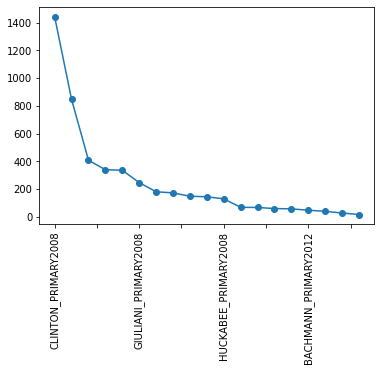

In [6]:
df_stats['#docs'].sort_values(ascending=False).plot(marker='o', rot=90)